# Bike Sharing in Washington D.C.

Statistical Programming - Python | MBD OCT 2018  
*IE School of Human Sciences and Technology*  

***

## Introduction

### Objectives

This case study of the Washington D.C Bike Sharing System aims to predict the total number of users on an hourly basis. The dataset is [available on Kaggle](https://www.kaggle.com/marklvl/bike-sharing-dataset/home). It contains usage information of years 2011 and 2012.

All the files of this project are saved in a [GitHub repository](https://github.com/ashomah/Bike-Sharing-in-Washington).

### Libraries

This project uses a set of libraries for data manipulation, ploting and modelling.

In [1]:
# Loading Libraries
import pandas as pd #Data Manipulation
import numpy as np #Data Manipulation
import datetime

import matplotlib.pyplot as plt #Plotting
import matplotlib.ticker as ticker #Plotting
import seaborn as sns #Plotting
sns.set(style='white')

from sklearn import preprocessing #Preprocessing

from scipy.stats import skew, boxcox_normmax #Preprocessing
from scipy.special import boxcox1p #Preprocessing

from sklearn.model_selection import train_test_split #Train/Test Split
from sklearn import datasets, linear_model #Model
from sklearn.linear_model import LinearRegression #Model

from sklearn.metrics import mean_squared_error, r2_score #Metrics
from sklearn.metrics import accuracy_score #Metrics
from sklearn.model_selection import cross_val_score, cross_val_predict # CV
from sklearn.feature_selection import RFE #Feature Selection



### Data Loading

The dataset is stored in the [GitHub repository](https://github.com/ashomah/Bike-Sharing-in-Washington) consisting in two CSV file: `day.csv` and `hour.csv`. The files are loaded directly from the repository.

In [2]:
hours_df = pd.read_csv("https://raw.githubusercontent.com/ashomah/Bike-Sharing-in-Washington/master/Bike-Sharing-Dataset/hour.csv")
hours_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
days_df = pd.read_csv("https://raw.githubusercontent.com/ashomah/Bike-Sharing-in-Washington/master/Bike-Sharing-Dataset/day.csv")
days_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Data Preparation

### Variables Types and Definitions

The first stage of this analysis is to describe the dataset, understand the meaning of variable and perform the necessary adjustments to ensure that the data will be proceeded correctly during the Machine Learning process.

In [4]:
# Shape of the data frame
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('hour.csv:', hours_df.shape[0],'rows |', hours_df.shape[1], 'columns'))
print('{:<9} {:>6} {:>6} {:>3} {:>6}'.format('day.csv:', days_df.shape[0],'rows |', days_df.shape[1], 'columns'))

hour.csv:  17379 rows |  17 columns
day.csv:     731 rows |  16 columns


In [5]:
# Describe each variable
def df_desc(df):
    import pandas as pd
    desc = pd.DataFrame({'dtype': df.dtypes,
                         'NAs': df.isna().sum(),
                         'Numerical': (df.dtypes != 'object') & (df.dtypes != 'datetime64[ns]') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                         'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                         'Categorical': df.dtypes == 'object',
                         'Date': df.dtypes == 'datetime64[ns]',
                        })
    return desc

In [6]:
df_desc(days_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
instant,int64,0,True,False,False,False
dteday,object,0,False,False,True,False
season,int64,0,True,False,False,False
yr,int64,0,False,True,False,False
mnth,int64,0,True,False,False,False
holiday,int64,0,False,True,False,False
weekday,int64,0,True,False,False,False
workingday,int64,0,False,True,False,False
weathersit,int64,0,True,False,False,False
temp,float64,0,True,False,False,False


In [7]:
df_desc(hours_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
instant,int64,0,True,False,False,False
dteday,object,0,False,False,True,False
season,int64,0,True,False,False,False
yr,int64,0,False,True,False,False
mnth,int64,0,True,False,False,False
hr,int64,0,True,False,False,False
holiday,int64,0,False,True,False,False
weekday,int64,0,True,False,False,False
workingday,int64,0,False,True,False,False
weathersit,int64,0,True,False,False,False


The dataset `day.csv` consists in 731 rows and 16 columns. The dataset `hour.csv` consists in 17,379 rows and 17 columns. Both datasets have the same columns, with an additional column for hours in `hour.csv`.

Each row provides information for each day or each hour. None of the attributes contains any NA. Four (4) of these attributes contain decimal numbers, nine (9) contain integers, three (3) contain booleans, and one (1) contains date values stored as string.

For better readability, the columns of both data frames are renamed and data types are adjusted.

In [8]:
# HOURS DATASET
# Renaming columns names to more readable names
hours_df.rename(columns={'instant':'id',
                        'dteday':'date',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_bikes',
                        'hr':'hour',
                        'yr':'year',
                        'temp':'actual_temp',
                        'atemp':'feeling_temp'},
                inplace=True)

# Date time conversion
hours_df.date = pd.to_datetime(hours_df.date, format='%Y-%m-%d')

# Categorical variables
for column in ['season', 'holiday', 'weekday', 'workingday', 'weather_condition','month', 'year','hour']:
    hours_df[column] = hours_df[column].astype('category')
    
# DAYS DATASET
# Renaming columns names to more readable names
days_df.rename(columns={'instant':'id',
                        'dteday':'date',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_bikes',
                        'yr':'year',
                        'temp':'actual_temp',
                        'atemp':'feeling_temp'},
               inplace=True)

# Date time conversion
days_df.date = pd.to_datetime(days_df.date, format='%Y-%m-%d')

# Categorical variables
for column in ['season', 'holiday', 'weekday', 'workingday', 'weather_condition','month', 'year']:
    days_df[column] = days_df[column].astype('category')

In [9]:
hours_df.head()

,id,date,season,year,month,hour,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [10]:
hours_df.describe()

,id,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [11]:
# Lists values of categorical variables
categories = {'season': hours_df['season'].unique().tolist(),
              'year':hours_df['year'].unique().tolist(),
              'month':hours_df['month'].unique().tolist(),
              'hour':hours_df['hour'].unique().tolist(),
              'holiday':hours_df['holiday'].unique().tolist(),
              'weekday':hours_df['weekday'].unique().tolist(),
              'workingday':hours_df['workingday'].unique().tolist(),
              'weather_condition':hours_df['weather_condition'].unique().tolist(),
             }
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print()

holiday:
[0, 1]

hour:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

month:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

season:
[1, 2, 3, 4]

weather_condition:
[1, 2, 3, 4]

weekday:
[6, 0, 1, 2, 3, 4, 5]

workingday:
[0, 1]

year:
[0, 1]


In [12]:
df_desc(hours_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
hour,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False


In [13]:
days_df.head()

,id,date,season,year,month,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [14]:
days_df.describe()

,id,actual_temp,feeling_temp,humidity,windspeed,casual,registered,total_bikes
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [15]:
# Lists values of categorical variables
categories = {'season': days_df['season'].unique().tolist(),
              'year':days_df['year'].unique().tolist(),
              'month':days_df['month'].unique().tolist(),
              'holiday':days_df['holiday'].unique().tolist(),
              'weekday':days_df['weekday'].unique().tolist(),
              'workingday':days_df['workingday'].unique().tolist(),
              'weather_condition':days_df['weather_condition'].unique().tolist(),
             }
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print()

holiday:
[0, 1]

month:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

season:
[1, 2, 3, 4]

weather_condition:
[2, 1, 3]

weekday:
[6, 0, 1, 2, 3, 4, 5]

workingday:
[0, 1]

year:
[0, 1]


In [16]:
df_desc(days_df)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False
actual_temp,float64,0,True,False,False,False


The datasets contain 17 variables with no NAs:

- `id`: numerical, integer values.  
  *Record index.*
  
  
- `date`: numerical, date values.  
  *Date.*


- `season`: encoded categorical, integer between 1 and 4.  
  *Season: 1=Spring, 2=Summer, 3=Fall, 4=Winter.*


- `year`: encoded categorical, integer between 0 and 1.  
  *Year: 0=2011, 1=2012.*
  
  
- `month`: encoded categorical, integer between 1 and 12.  
  *Month.*
  
  
- `hour`: encoded categorical, integer between 1 and 23.  
  *Hour.*
  
  
- `holiday`: encoded categorical, boolean.  
  *Flag indicating if the day is a holiday.*


- `weekday`: encoded categorical, integer between 0 and 6.  
  *Day of the week (0=Sunday, ... 6=Saturday).*


- `workingday`: encoded categorical, boolean.  
  *Flag indicating if the day is a working day.*
  
  
- `weather_condition`: encoded categorical, integer between 1 and 4.  
  *Weather condition (1=Clear, 2=Mist, 3=Light Rain, 4=Heavy Rain).*


- `actual_temp`: numerical, decimal values between 0 and 1.  
  *Normalized temperature in Celsius (min = -16, max = +50).*


- `feeling_temp`: numerical, decimal values between 0 and 1.  
  *Normalized feeling temperature in Celsius (min = -8, max = +39).*


- `humidity`: numerical, decimal values between 0 and 1.  
  *Normalized humidity.*


- `windspeed`: numerical, decimal values between 0 and 1.  
  *Normalized wind speed.*


- `casual`: numerical, integer.  
  *Count of casual users.*


- `registered`: numerical, integer.  
  *Count of registered users. This variable won't be considered in the study.*


- `total_bikes`: numerical, integer.  
  *Count of total rental bikes (casual+registered). This is the __target variable__ of the study, the one to be modelled.*

### Exploratory Data Analysis

#### Bike sharing utilization over the two years

The objective of this study is to build a model to predict the value of the variable `total_bikes`, based on the other variables available.

/Users/Ashley/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


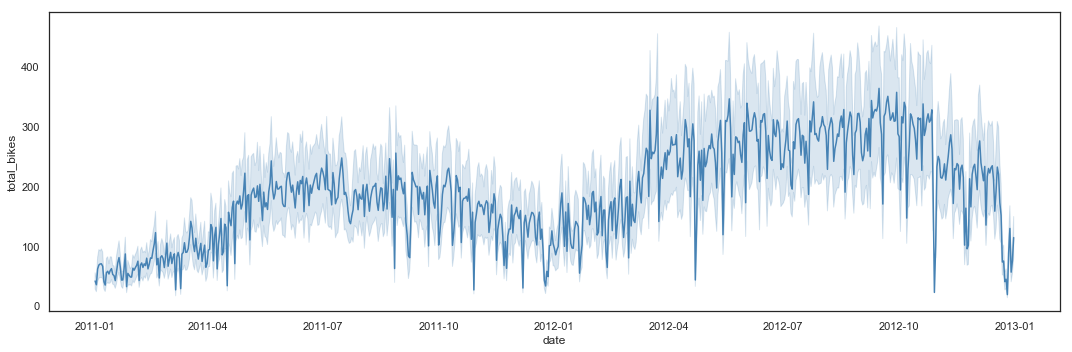

In [17]:
# Total_bikes evolution per day
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.date,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

Based on the two years dataset, it seems that the utilization of the bike sharing service has increased over the period. The number of bikes rented per day also seems to vary depending on the season, with Spring and Summer months being showing a higher utilization of the service.

#### Bike sharing utilization by Month

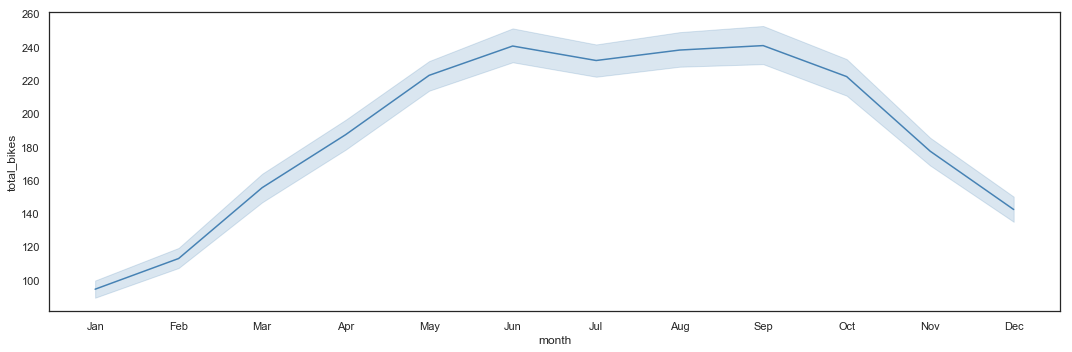

In [18]:
# Total_bikes by Month - Line Plot
plt.figure(figsize=(15,5))
g = sns.lineplot(x = hours_df.month,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.tight_layout()

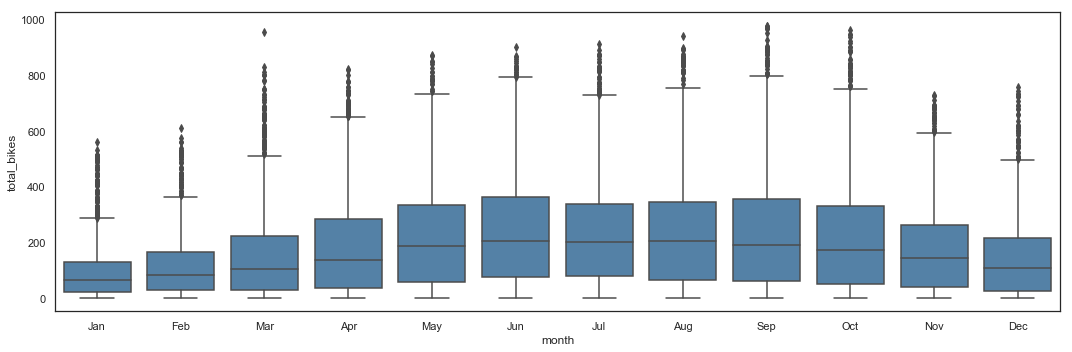

In [19]:
# Total_bikes by Month - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.month,
            y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()

The average utilization per month seems to increase between April and October, with a higher variance too.

#### Bike sharing utilization by Hour

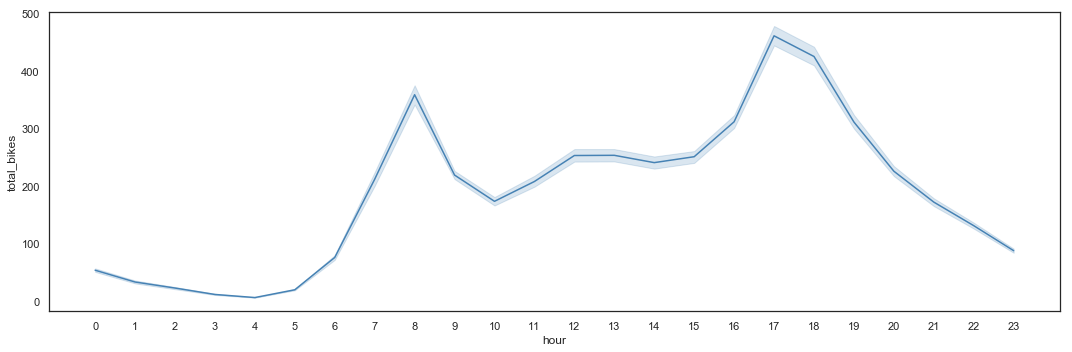

In [20]:
# Total_bikes by Hour - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.hour,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.xticks([0, 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
plt.tight_layout()

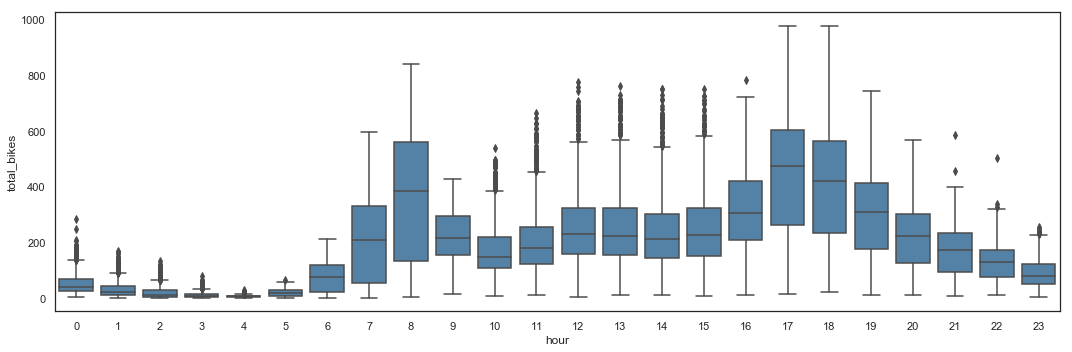

In [21]:
# Total_bikes by Hour - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.hour,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

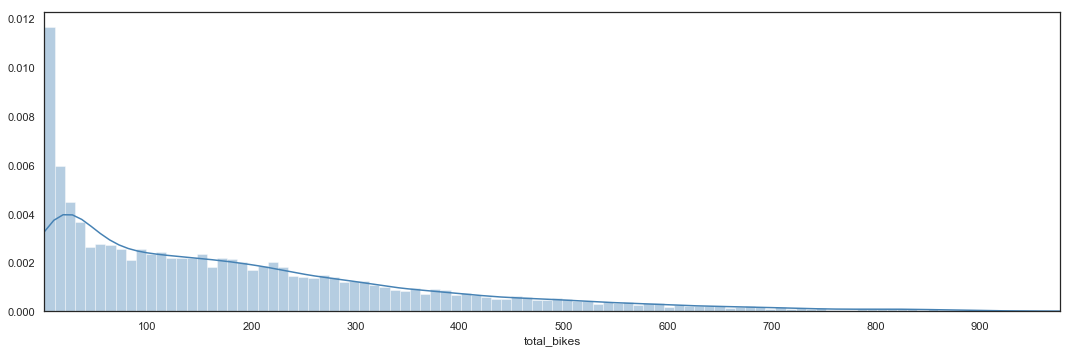

In [22]:
# Total_bikes by Hour - Distribution
plt.figure(figsize=(15,5))
sns.distplot(hours_df.total_bikes,
             bins = 100,
             color = 'steelblue').axes.set(xlim = (min(hours_df.total_bikes),max(hours_df.total_bikes)),
                                           xticks = [0,100,200,300,400,500,600,700,800,900,1000])
plt.tight_layout()

The utilization seems really similar over the day, with 2 peaks around 8am and between 5pm and 6pm. The box plot shows potential outliers in the data, which will be removed after the Feature Construction stage. It also highlight an important variance during day time, especially at peak times. The distribution plot shows that utilization is most of the time below 40 bikes simultaneously, and can reach about 1,000 bikes.

#### Bike sharing utilization by Season

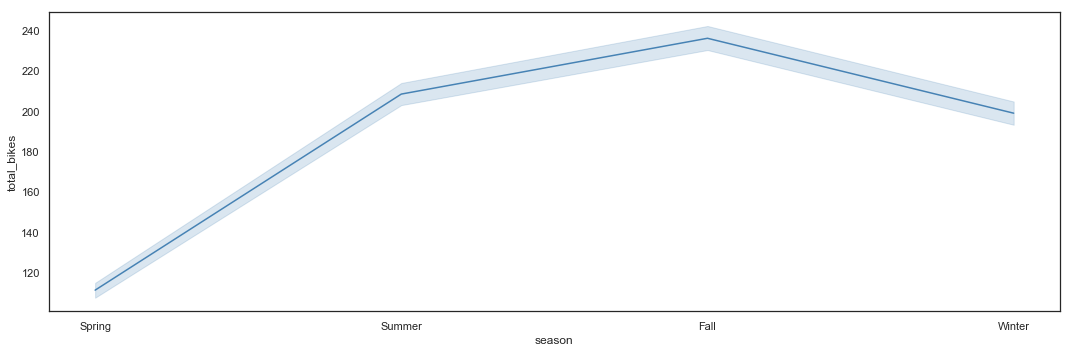

In [23]:
# Total_bikes by Season - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.season,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
plt.xticks([1,2,3,4])
plt.tight_layout()

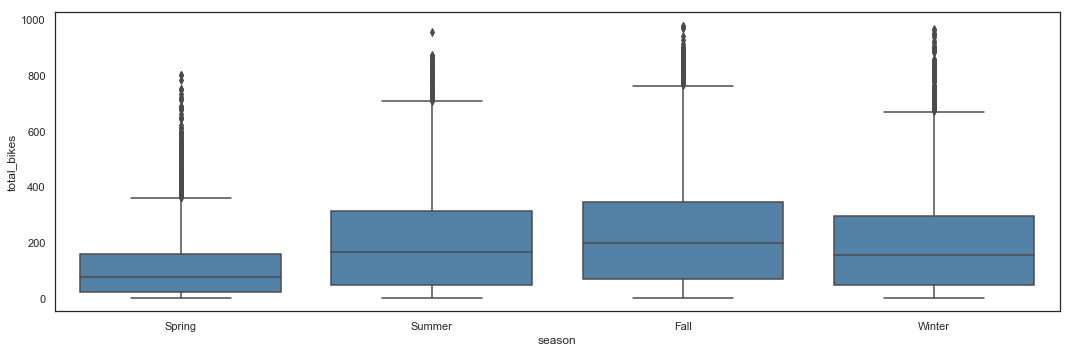

In [24]:
# Total_bikes by Season - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.season,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Spring', 'Summer', 'Fall', 'Winter'])
plt.tight_layout()

Fall appears to be the high season, with Summer and Winter having similar utilization shapes. Spring appears to be the low season with, however, potential utilization peaks which can reach the same number of bikes than in high season.

#### Bike sharing utilization by Holiday

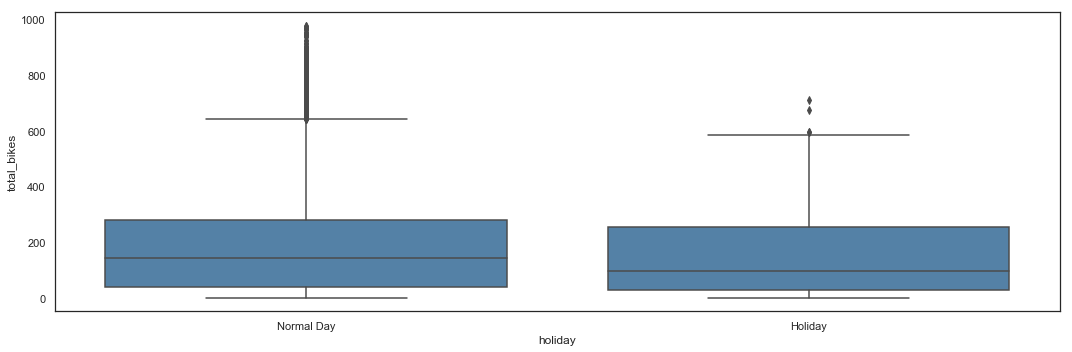

In [25]:
# Total_bikes by Holidays - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.holiday,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Normal Day', 'Holiday'])
plt.tight_layout()

Utilization of bikes during holidays seems lower and with less peaks.

#### Bike sharing utilization by Weekday

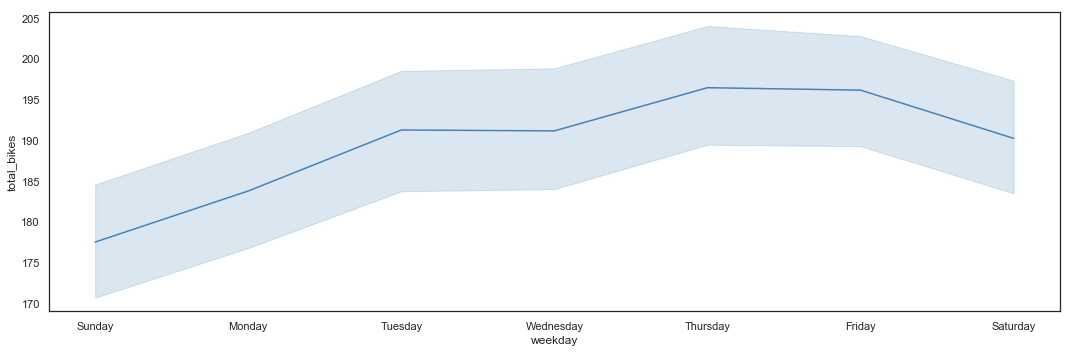

In [26]:
# Total_bikes by Weekday - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.weekday,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.xticks([0,1,2,3,4,5,6])
plt.tight_layout()

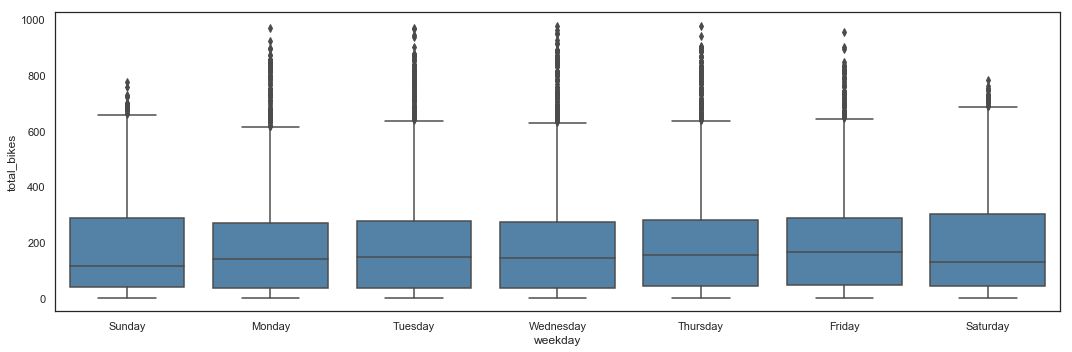

In [27]:
# Total_bikes by Weekday - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.weekday,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.tight_layout()

The average utilization per hour seems higher at the end of the week, but overall, weekends appear to have lower frequentation and weekdays have higher peaks.

#### Bike sharing utilization by Working Day

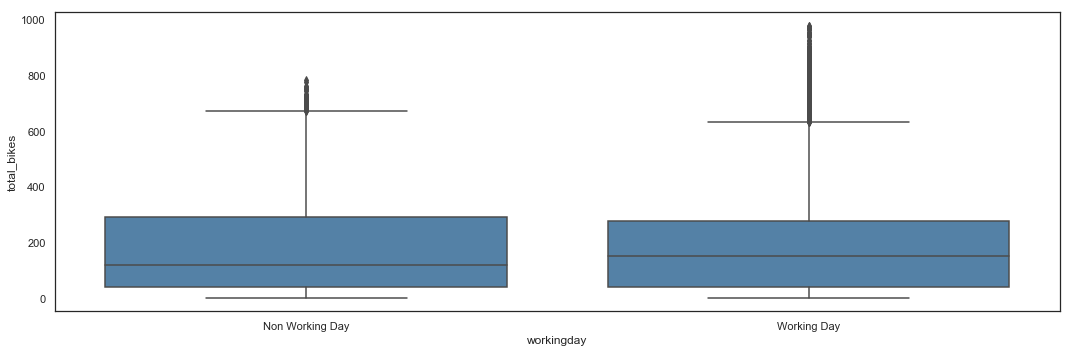

In [28]:
# Total_bikes by Working Day - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.workingday,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Non Working Day', 'Working Day'])
plt.tight_layout()

Utilization seems higher during working days, with higher peaks.

#### Bike sharing utilization by Weather Condition

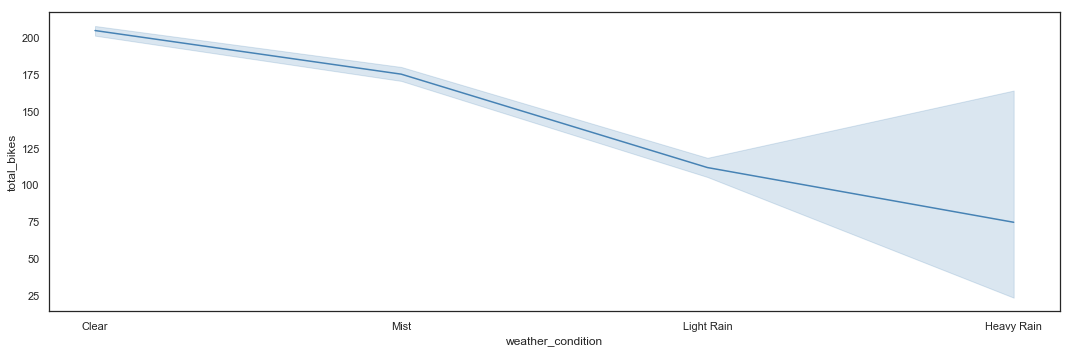

In [29]:
# Total_bikes by Weather Condition - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.weather_condition,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Clear', 'Mist', 'Light Rain', 'Heavy Rain'])
plt.xticks([1,2,3,4])
plt.tight_layout()

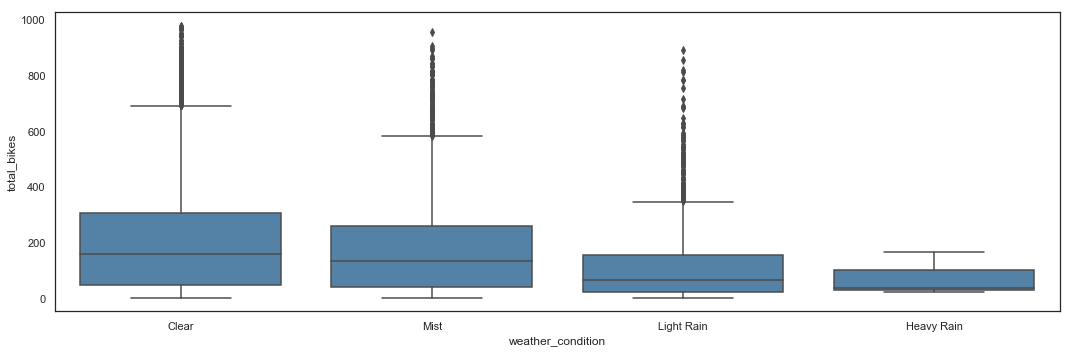

In [30]:
# Total_bikes by Weather Condition - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.weather_condition,
             y = hours_df.total_bikes,
             color = 'steelblue') \
   .axes.set_xticklabels(['Clear', 'Mist', 'Light Rain', 'Heavy Rain'])
plt.tight_layout()

Unsurprisingly, bike sharing utilization is getting worse with bad weather.

#### Bike sharing utilization by Actual Temperature

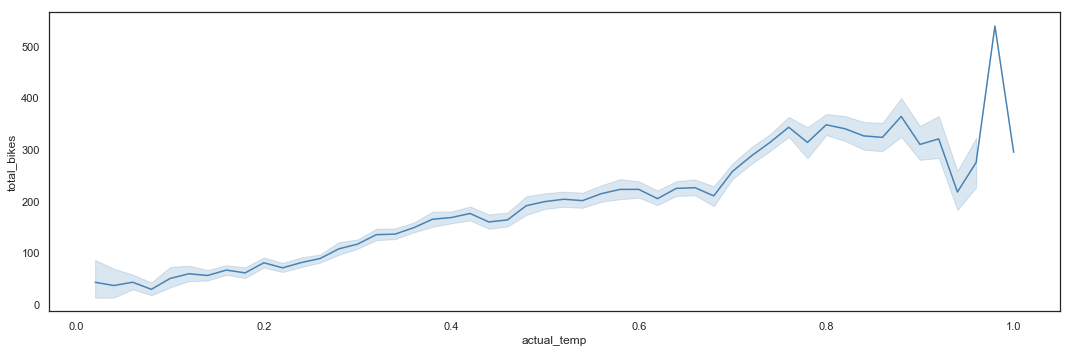

In [31]:
# Total_bikes by Actual Temperature - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.actual_temp,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

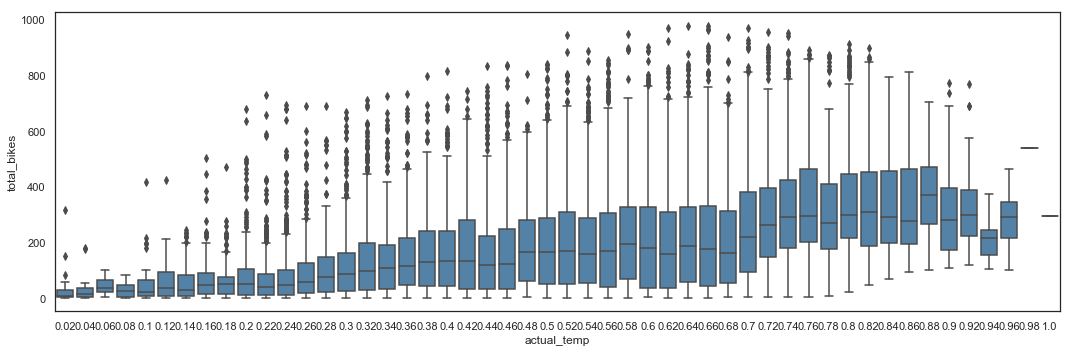

In [32]:
# Total_bikes by Actual Temperature - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.actual_temp,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

The utilization is almost inexistant for sub-zero temperatures. It then grows with the increase of temperature, but drops down when it gets extremely hot.

#### Bike sharing utilization by Feeling Temperature

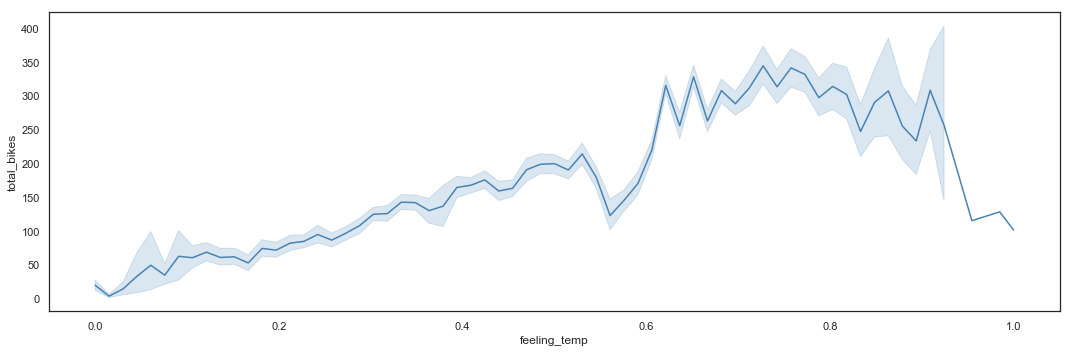

In [33]:
# Total_bikes by Feeling Temperature - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.feeling_temp,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

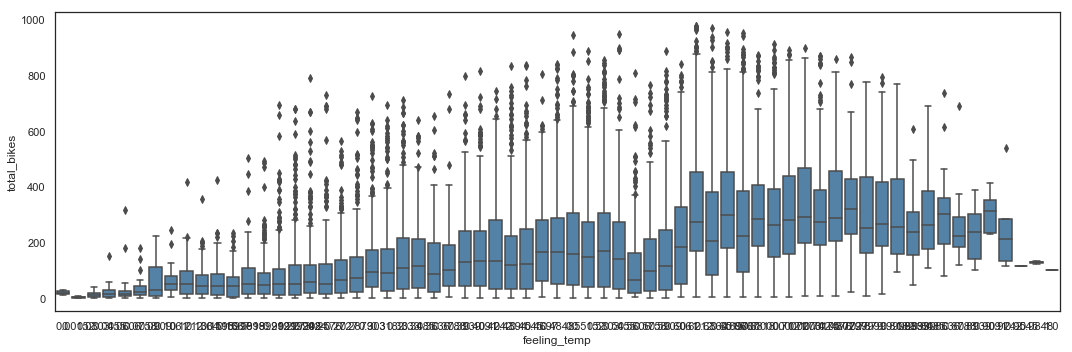

In [34]:
# Total_bikes by Feeling Temperature - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.feeling_temp,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

The utilization by feeling temperature follows the same rules than by actual temperature.

#### Bike sharing utilization by Humidity

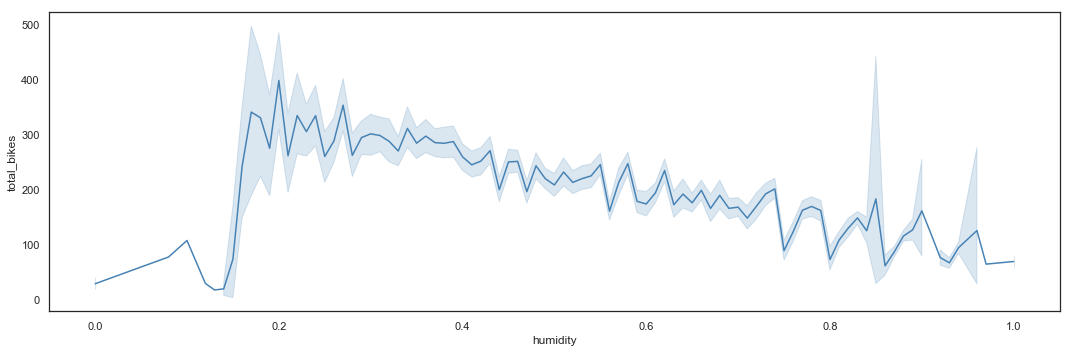

In [35]:
# Total_bikes by Humidity - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.humidity,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

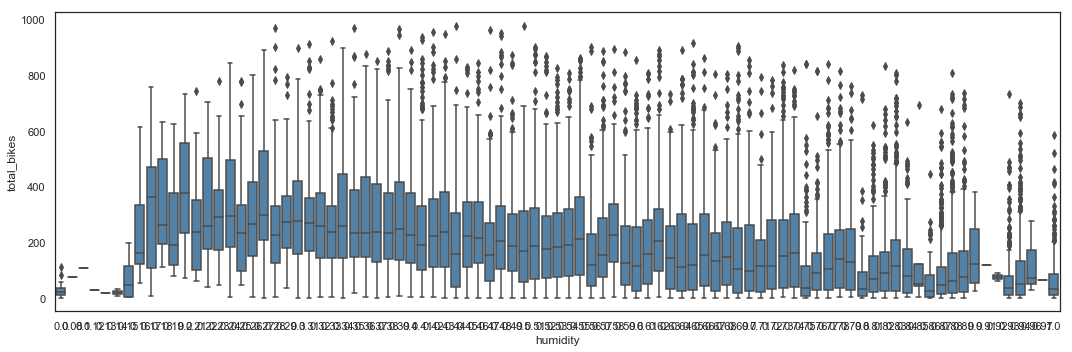

In [36]:
# Total_bikes by Humidity - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.humidity,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

The utilization of bike sharing services is decreasing with the increase of humidity.

#### Bike sharing utilization by Wind Speed

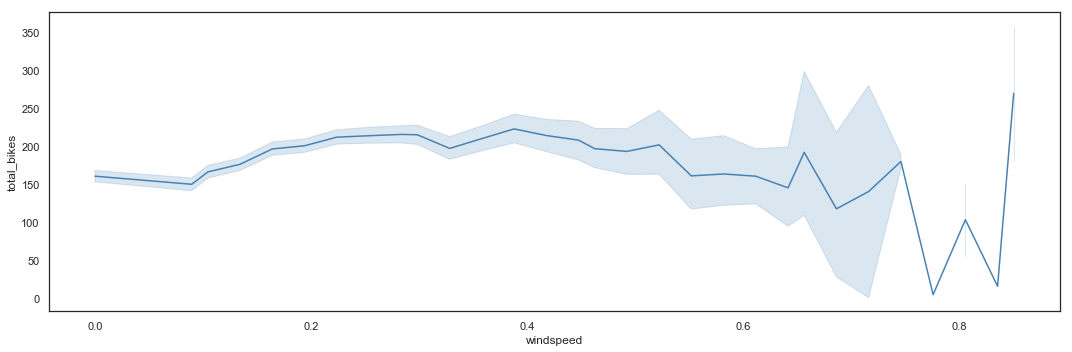

In [37]:
# Total_bikes by Wind Speed - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(x = hours_df.windspeed,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

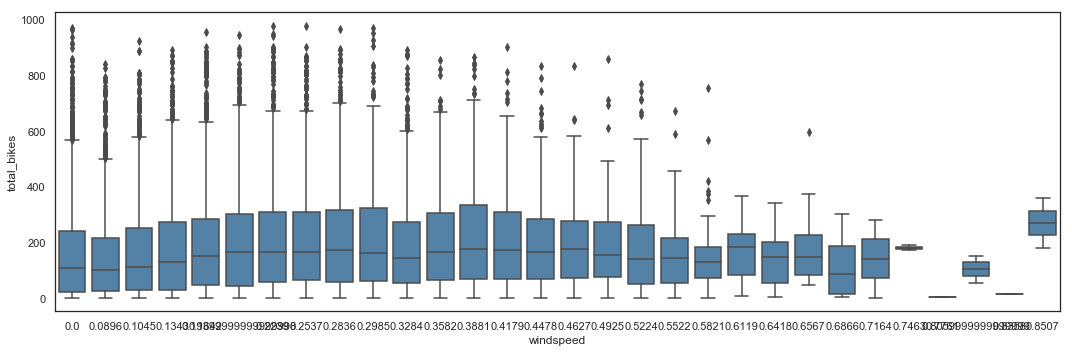

In [38]:
# Total_bikes by Wind Speed - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(x = hours_df.windspeed,
             y = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

Stronger wind seems to discourage users to use the bike sharing service.

#### Bike sharing utilization by Casual

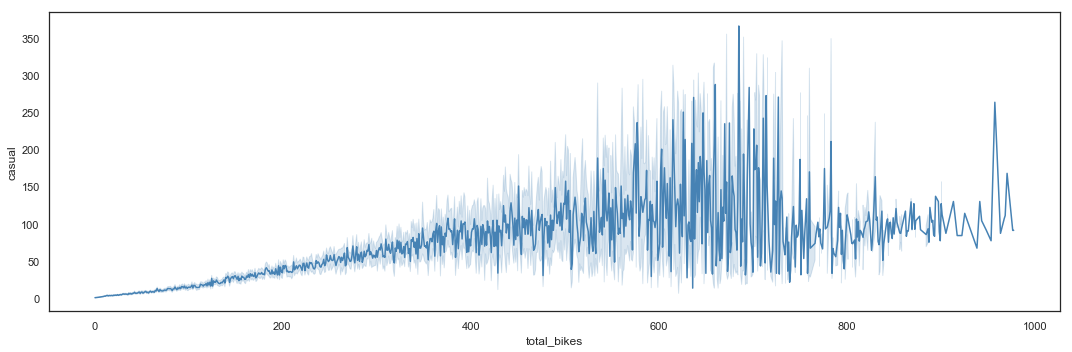

In [39]:
# Total_bikes by Casual - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(y = hours_df.casual,
             x = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

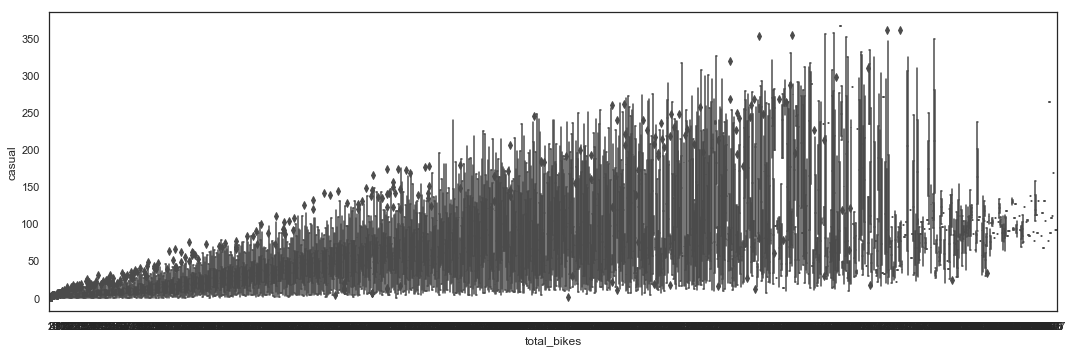

In [40]:
# Total_bikes by Casual - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(y = hours_df.casual,
            x = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

Stronger wind seems to discourage users to use the bike sharing service.

#### Bike sharing utilization by Registered

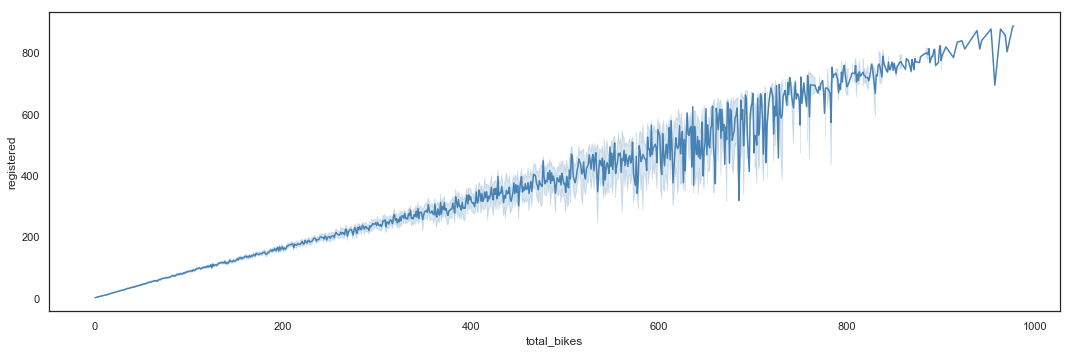

In [41]:
# Total_bikes by Registered - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(y = hours_df.registered,
             x = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

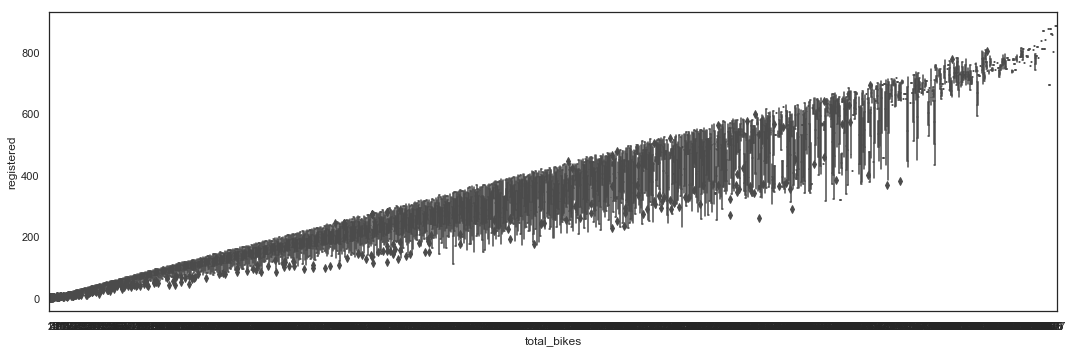

In [42]:
# Total_bikes by Registered - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(y = hours_df.registered,
            x = hours_df.total_bikes,
             color = 'steelblue')
plt.tight_layout()

Stronger wind seems to discourage users to use the bike sharing service.

#### Casual vs Registered Users

In [43]:
cas_reg = pd.DataFrame(hours_df.registered)
cas_reg['casual'] = hours_df.casual
cas_reg['total_bikes'] = hours_df.total_bikes
cas_reg['ratio_cas_tot'] = np.where(cas_reg.total_bikes == 0,0,round(cas_reg.casual / cas_reg.total_bikes,4))
cas_reg['diff_cas_reg'] = cas_reg.registered - cas_reg.casual
cas_reg.describe()

,registered,casual,total_bikes,ratio_cas_tot,diff_cas_reg
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,153.786869,35.676218,189.463088,0.172142,118.110651
std,151.357286,49.305030,181.387599,0.136557,133.336293
min,0.000000,0.000000,1.000000,0.000000,-131.000000
25%,34.000000,4.000000,40.000000,0.063500,24.000000
50%,115.000000,17.000000,142.000000,0.146900,80.000000
75%,220.000000,48.000000,281.000000,0.253700,154.000000
max,886.000000,367.000000,977.000000,1.000000,804.000000


/Users/Ashley/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


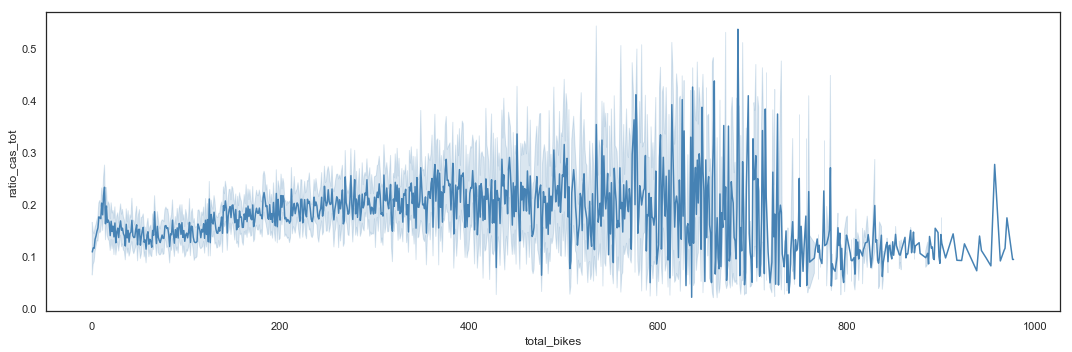

In [44]:
# Total_bikes by Registered - Line Plot
plt.figure(figsize=(15,5))
sns.lineplot(y = cas_reg.ratio_cas_tot,
             x = cas_reg.total_bikes,
             color = 'steelblue')
plt.tight_layout()

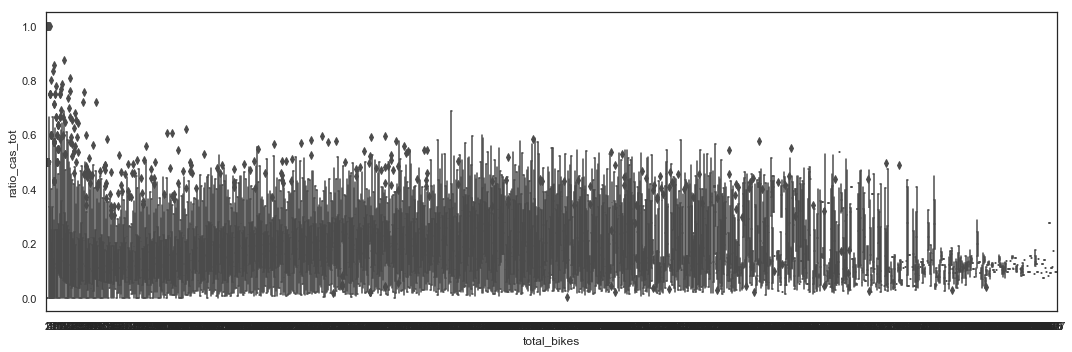

In [45]:
# Total_bikes by Registered - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(y = cas_reg.ratio_cas_tot,
            x = cas_reg.total_bikes,
             color = 'steelblue')
plt.tight_layout()

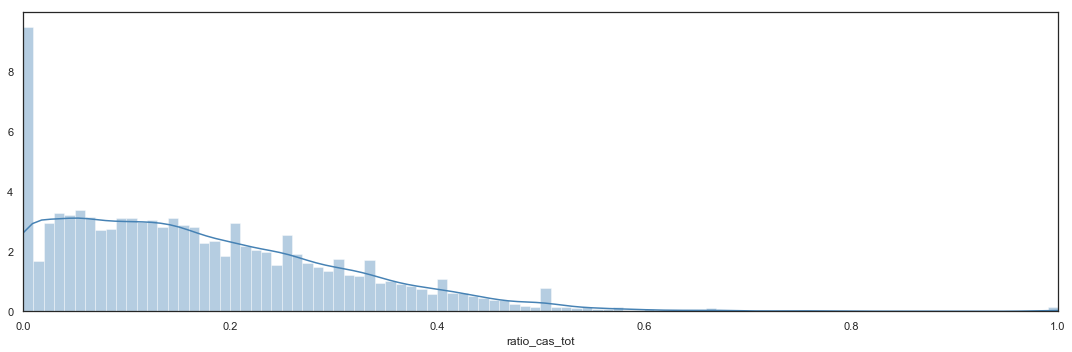

In [46]:
# Total_bikes by Hour - Distribution
plt.figure(figsize=(15,5))
sns.distplot(cas_reg.ratio_cas_tot,
             bins = 100,
             color = 'steelblue').axes.set(xlim = (min(cas_reg.ratio_cas_tot),max(cas_reg.ratio_cas_tot)))
plt.tight_layout()

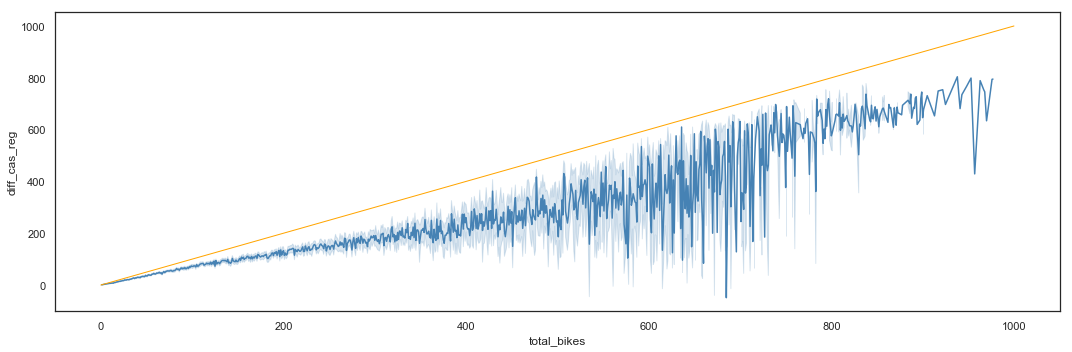

In [47]:
# Total_bikes by Registered - Line Plot
x_plot = np.linspace(0, 1000, 1000)
plt.figure(figsize=(15,5))
sns.lineplot(y = cas_reg.diff_cas_reg,
             x = cas_reg.total_bikes,
             color = 'steelblue')
plt.plot(x_plot, x_plot, lw=1, linestyle = 'solid', color='orange')
plt.tight_layout()

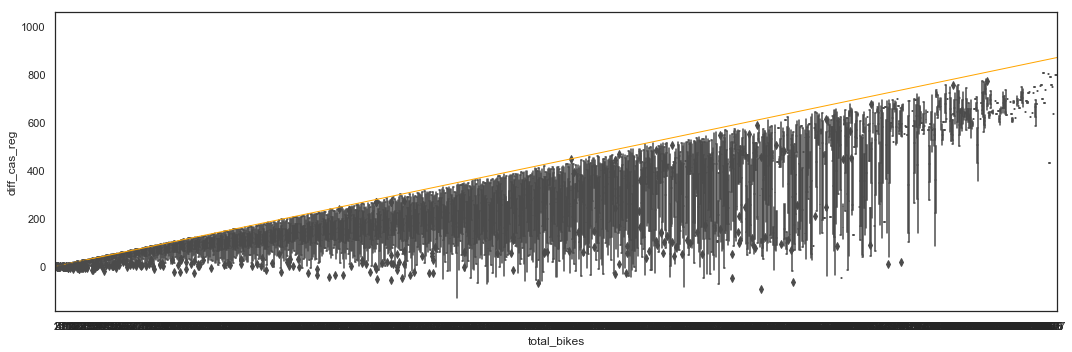

In [48]:
# Total_bikes by Registered - Box Plot
plt.figure(figsize=(15,5))
sns.boxplot(y = cas_reg.diff_cas_reg,
            x = cas_reg.total_bikes,
             color = 'steelblue')
plt.plot(x_plot, x_plot, lw=1, linestyle = 'solid', color='orange')
plt.tight_layout()

Stronger wind seems to discourage users to use the bike sharing service.

#### PLOT 1

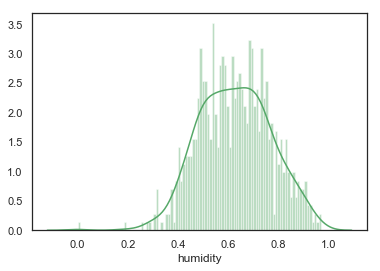

In [49]:
sns.distplot(days_df['humidity'], color='g', bins=100, hist_kws={'alpha': 0.4}) ;

#### PLOT 2

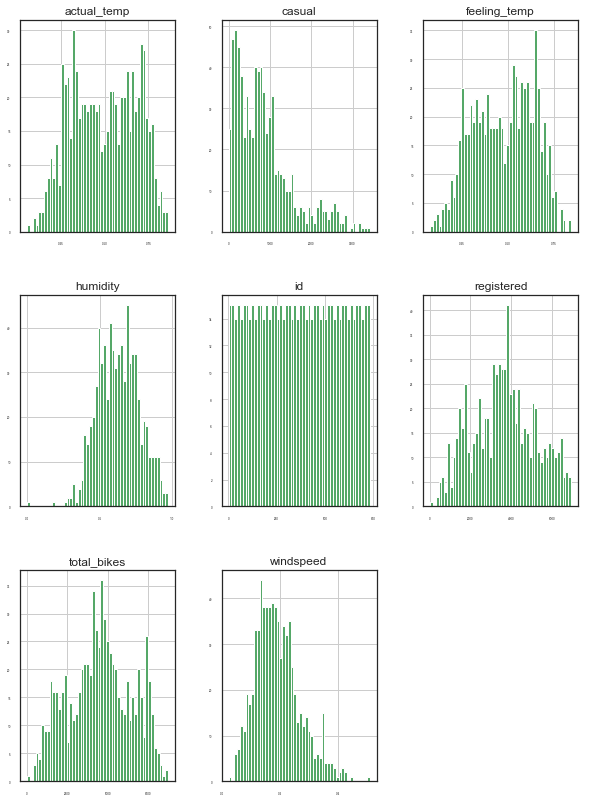

In [50]:
days_df_num = days_df.select_dtypes(include = ['float64', 'int64']);
days_df_num.hist(figsize=(10, 14), bins=50, xlabelsize=3, ylabelsize=3, color ='g');

#### PLOT 3

In [51]:
days_num_corr = days_df_num.corr()['total_bikes'][:-1] # -1 because the latest row is SalePrice
golden_features_list = days_num_corr[abs(days_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Total Bikes:\n{}".format(len(golden_features_list), golden_features_list))

There is 5 strongly correlated values with Total Bikes:
registered      0.945517
casual          0.672804
feeling_temp    0.631066
id              0.628830
actual_temp     0.627494
Name: total_bikes, dtype: float64


#### PLOT 4

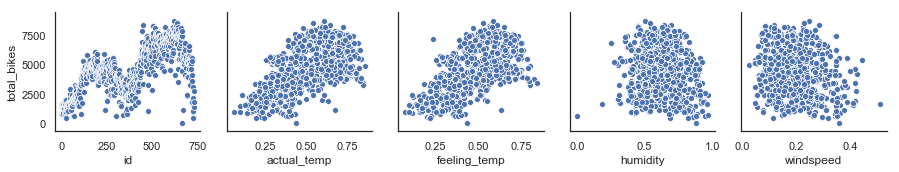

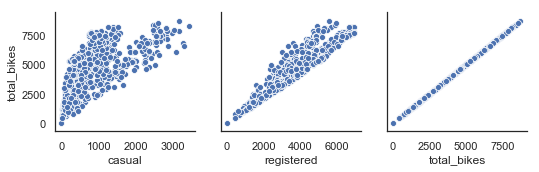

In [52]:
for i in range(0, len(days_df_num.columns), 5):
    sns.pairplot(data=days_df_num,
                x_vars=days_df_num.columns[i:i+5],
                y_vars=['total_bikes'])

#### Correlation Analysis

A correlation analysis will allow to identify relationships between the dataset variables. A plot of their distributions highlighting the value of the target variable might also reveal some patterns.

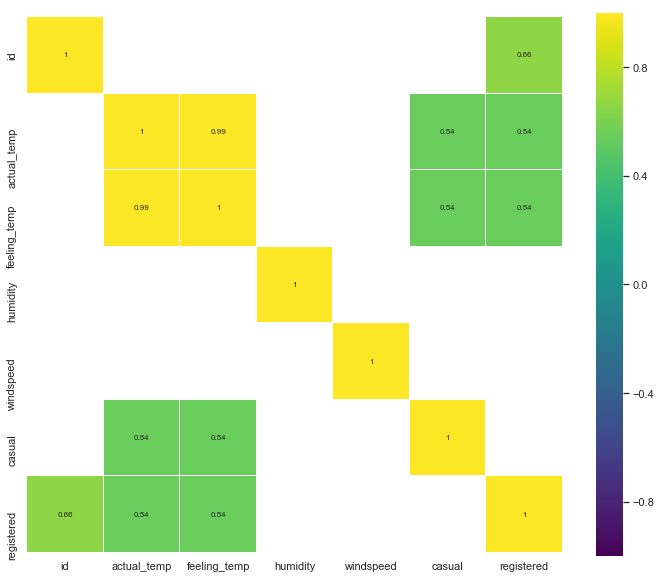

In [53]:
corr = days_df_num.drop('total_bikes', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

#### PLOT 5

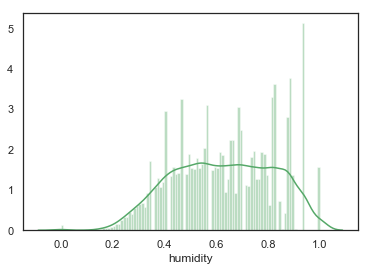

In [54]:
sns.distplot(hours_df['humidity'], color='g', bins=100, hist_kws={'alpha': 0.4}) ;

#### PLOT 6

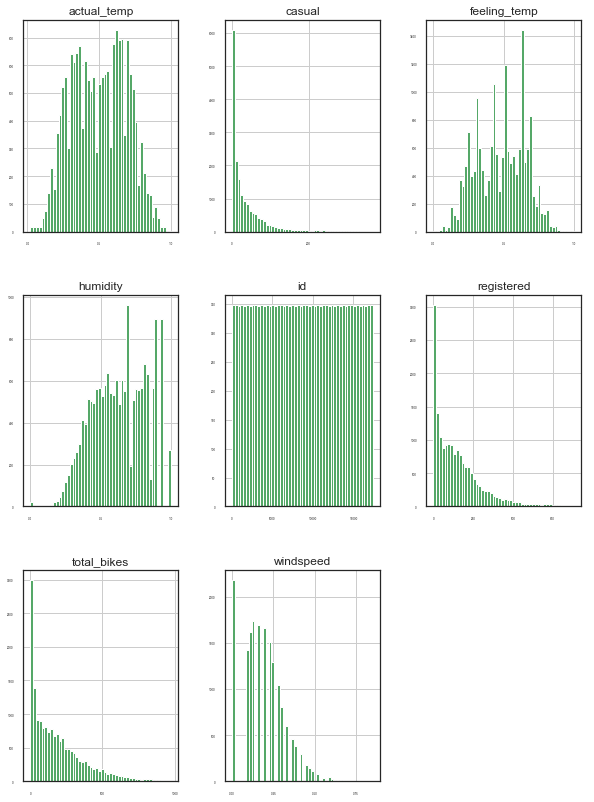

In [55]:
hours_df_num = hours_df.select_dtypes(include = ['float64', 'int64']);
hours_df_num.hist(figsize=(10, 14), bins=50, xlabelsize=3, ylabelsize=3, color='g');

#### PLOT 7

In [56]:
hours_num_corr = hours_df_num.corr()['total_bikes'][:-1] # -1 because the latest row is SalePrice
golden_features_list_1 = hours_num_corr[abs(hours_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with Total Bikes:\n{}".format(len(golden_features_list_1), golden_features_list_1))

There is 2 strongly correlated values with Total Bikes:
registered    0.972151
casual        0.694564
Name: total_bikes, dtype: float64


#### PLOT 8

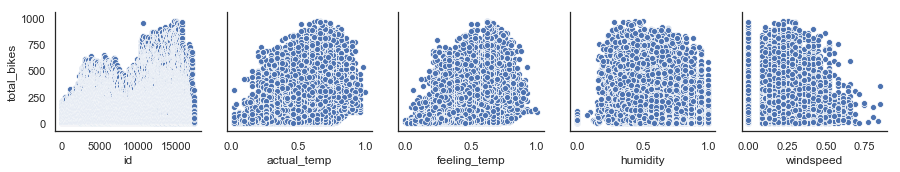

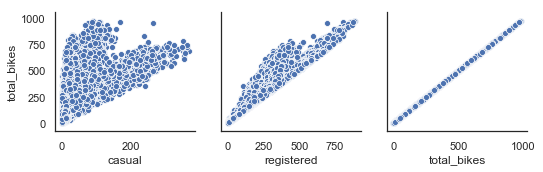

In [57]:
for i in range(0, len(hours_df_num.columns), 5):
    sns.pairplot(data=hours_df_num,
                x_vars=hours_df_num.columns[i:i+5],
                y_vars=['total_bikes'])

#### PLOT 9

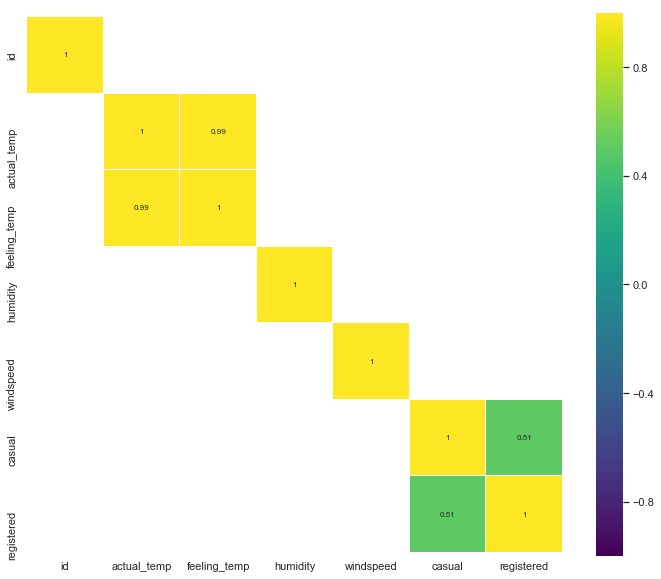

In [58]:
corr_1 = hours_df_num.drop('total_bikes', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr_1[(corr_1 >= 0.5) | (corr_1 <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

#### PLOT 10

In [59]:
hours_df_cat = hours_df.select_dtypes(include = ['category']);
hours_df_cat.head()

,season,year,month,hour,holiday,weekday,workingday,weather_condition
0,1,0,1,0,0,6,0,1
1,1,0,1,1,0,6,0,1
2,1,0,1,2,0,6,0,1
3,1,0,1,3,0,6,0,1
4,1,0,1,4,0,6,0,1


#### PLOT 11

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

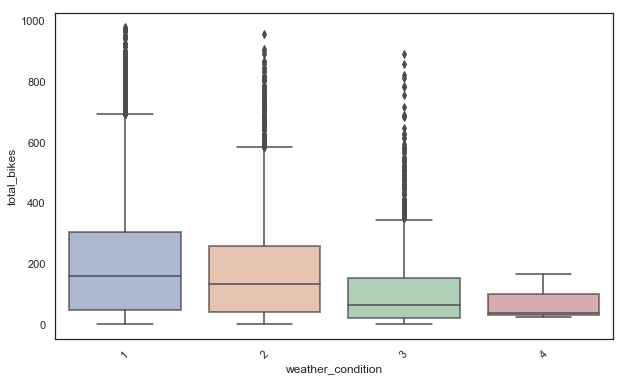

In [60]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='weather_condition', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

#### PLOT 12

(array([0, 1]), <a list of 2 Text xticklabel objects>)

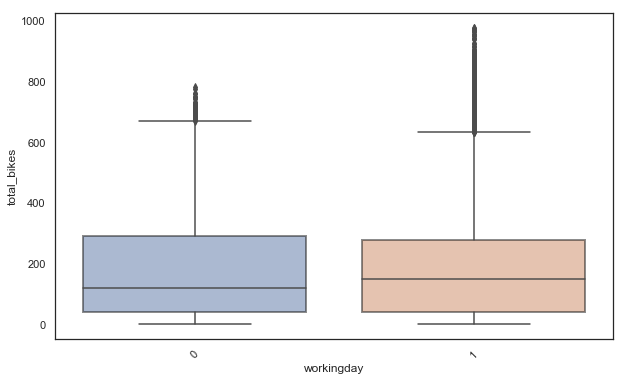

In [61]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='workingday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

#### PLOT 13

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

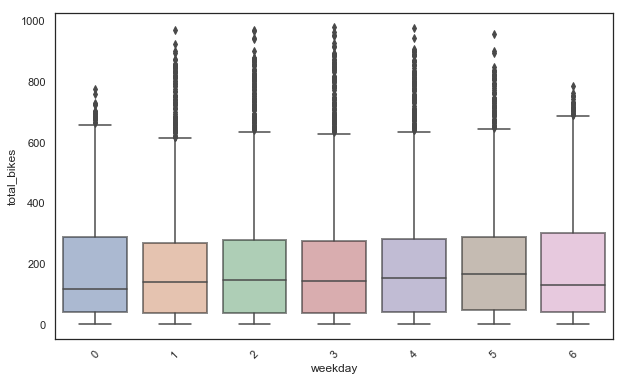

In [62]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='weekday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

#### PLOT 14

(array([0, 1]), <a list of 2 Text xticklabel objects>)

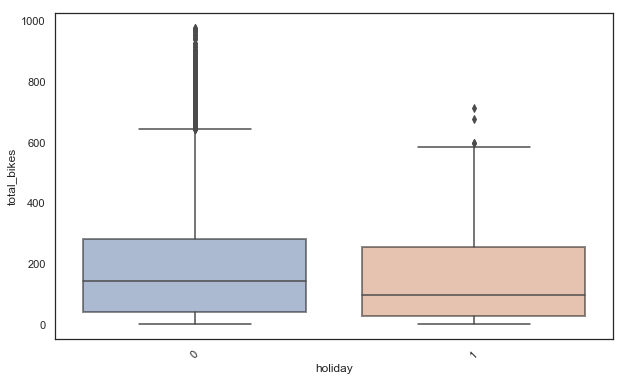

In [63]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='holiday', y='total_bikes', data=hours_df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [64]:
hours_df.isnull().values.any()
hours_df.isnull().sum()

id                   0
date                 0
season               0
year                 0
month                0
hour                 0
holiday              0
weekday              0
workingday           0
weather_condition    0
actual_temp          0
feeling_temp         0
humidity             0
windspeed            0
casual               0
registered           0
total_bikes          0
dtype: int64

In [65]:
days_df.isnull().values.any()
days_df.isnull().sum()

id                   0
date                 0
season               0
year                 0
month                0
holiday              0
weekday              0
workingday           0
weather_condition    0
actual_temp          0
feeling_temp         0
humidity             0
windspeed            0
casual               0
registered           0
total_bikes          0
dtype: int64

### Encoding / Scaling / Skewness

In [66]:
hours_prep = hours_df.copy()
days_prep = days_df.copy()

In [67]:
hours_prep= hours_prep.drop(['registered'], axis=1)
days_prep = days_prep.drop(['registered'], axis=1)
df_desc(hours_prep)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
date,datetime64[ns],0,False,False,False,True
season,category,0,True,False,False,False
year,category,0,False,True,False,False
month,category,0,True,False,False,False
hour,category,0,True,False,False,False
holiday,category,0,False,True,False,False
weekday,category,0,True,False,False,False
workingday,category,0,False,True,False,False
weather_condition,category,0,True,False,False,False


In [68]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

In [69]:
fix_skewness(hours_prep)
fix_skewness(days_prep)

,id,date,season,year,month,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual,total_bikes
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.120563,16.683486,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.163106,11.659472,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.163010,11.256907,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.120480,10.788111,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.134655,9.635480,1600
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.075832,9.921293,1606
6,7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.125109,12.238744,1510
7,8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.170517,8.908775,959
8,9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.203103,8.072883,822
9,10,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.152122,7.153922,1321


In [70]:
def date_features(df):
    columns = df.columns
    return df.select_dtypes(include=[np.datetime64]).columns

def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    date_columns = date_features(df)
    return(list(set(df.columns) - set(numerical_columns) - set(date_columns) ))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

In [71]:
hours_prep_encoded = onehot_encode(hours_prep)
days_prep_encoded = onehot_encode(days_prep)
df_desc(hours_prep_encoded)

,dtype,NAs,Numerical,Boolean,Categorical,Date
id,int64,0,True,False,False,False
actual_temp,float64,0,True,False,False,False
feeling_temp,float64,0,True,False,False,False
humidity,float64,0,True,False,False,False
windspeed,float64,0,True,False,False,False
casual,float64,0,True,False,False,False
total_bikes,float64,0,True,False,False,False
workingday_0,uint8,0,False,True,False,False
workingday_1,uint8,0,False,True,False,False
hour_0,uint8,0,False,True,False,False


In [72]:
#def remove_outliers(df):
#    x = df.drop(['total_bikes','date'], axis=1)
#    y = df.total_bikes.reset_index(drop=True)
#    ols = sm.OLS(endog = y.astype(float), exog = x.astype(float))
#    fit = ols.fit()
#    test = fit.outlier_test()['bonf(p)']
#    outliers = list(test[test<1e-3].index) 
#    df.drop(df.index[outliers])
#    return df

In [73]:
# remove_outliers(hours_prep)

### Training/Test Split

In [74]:
train_set = pd.DataFrame(hours_prep)
X = train_set.iloc[:,:].drop(['total_bikes','date'], axis=1)
X_train = train_set.iloc[1:14491,:].drop(['total_bikes','date'], axis=1)
X_test = train_set.iloc[14492:,:].drop(['total_bikes','date'], axis=1)
X_train.head()

,id,season,year,month,hour,holiday,weekday,workingday,weather_condition,actual_temp,feeling_temp,humidity,windspeed,casual
1,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.000000,2.531634
2,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.000000,2.010221
3,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.000000,1.514787
4,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.000000,0.000000
5,6,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.084177,0.000000


In [75]:
test_set = pd.DataFrame(hours_prep)
y = test_set.iloc[:,15]
y_train = test_set.iloc[1:14491,15]
y_test = test_set.iloc[14492:,15]

In [76]:
print('Features:',X.shape[0], 'items | ', X.shape[1],'columns')
print('Target:',y.shape[0], 'items | ', 1,'columns')
print('Features Train:',X_train.shape[0], 'items | ', X_train.shape[1],'columns')
print('Features Test:',X_test.shape[0], 'items | ',  X_test.shape[1],'columns')
print('Target Train:',y_train.shape[0], 'items | ', 1,'columns')
print('Target Test:',y_test.shape[0], 'items | ', 1,'columns')

Features: 17379 items |  14 columns
Target: 17379 items |  1 columns
Features Train: 14490 items |  14 columns
Features Test: 2887 items |  14 columns
Target Train: 14490 items |  1 columns
Target Test: 2887 items |  1 columns


## Baseline

In [77]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

print('Intercept:', lm.intercept_)
print('Coefficients:', lm.coef_)
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Variance score (R2): {:.2f}'.format(r2_score(y_test, y_pred)))

Intercept: 0.6495598135230836
Coefficients: [ 8.39944699e-05  1.69071013e-01  9.13607664e-01  2.06058006e-02
  1.23478540e-01  2.14150161e-01  2.95308260e-02  2.84832006e+00
 -5.07869969e-02 -2.76340683e+00 -2.17360406e+00  2.92737515e-01
  1.07202150e+00  2.77161146e+00]
Mean squared error (MSE): 12.60
Variance score (R2): 0.75


## Feature Engineering

### Cross Validation Strategy

### Features Selection

## Final Metric

***

*Vratul Kapur | Irune Maury Arrue | Paul Jacques-Mignault | Sheena Miles | Ashley O’Mahony | Stavros Tsentemeidis | Karl Westphal  
O17 (Group G) | Master in Big Data and Business Analytics | Oct 2018 Intake | IE School of Human Sciences and Technology*

***